In [ ]:
#@title Student Information
#@markdown Enter the following info and run the cell:
Name = "mohammad yarmoghadam" #@param {type:"string"}
StudentNumber = 96462104 #@param {type:"integer"}

#Imports

In [ ]:
%%capture
!pip install transformers

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_datasets as tfds

from functools import reduce
import tarfile
import numpy as np
import re

import IPython
from IPython.display import clear_output 
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

from transformers import TFBertModel, BertTokenizer
%matplotlib inline

In [ ]:
!nvidia-smi # check if gpu mode is selected

Thu Jan  6 09:40:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

We will use a dataset consists of questions where a previously given single supporting fact, potentially amongst a set of other irrelevant facts, provides the answer. We first test one of the simplest cases of this, by asking for the location of a person, e.g. “$Mary$ $travelled$ $to$ $the$ $office.$ $Where$ $is$ $Mary?$”. It can be considered the
simplest case of some real world QA datasets.

About the dataset: https://research.fb.com/downloads/babi/

Lets download the dataset:

# 1. LSTM- Q&A



## 1.2 Preprocessing

Our model takes a discrete set of inputs $x_{1}, ..., x_{n}$ that are to be stored in the memory, a query $q$, and outputs an answer $a$. Each of the $x_{i}$, $q$, and $a$ contains symbols coming from a dictionary with $V$ words. The model writes all $x$ to the memory up to a fixed buffer size, and then finds a continuous representation for the $x$ and $q$. The continuous representation is then processed via multiple hops to
output $a$. This allows backpropagation of the error signal through multiple memory accesses back to the input during training. The overall model is shown in the next figure. During training, all three embedding matrices $A, B$ and $C$, as well as $W$ are jointly learned by minimizing a standard cross-entropy loss between $aˆ$ and the true
label $a$. Training is performed using stochastic gradient descent.


Delve more deeply into the details: https://arxiv.org/pdf/1503.08895.pdf

In [ ]:
%%capture
!wget https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz
!tar -xvzf babi_tasks_1-20_v1-2.tar.gz

In [ ]:
challenges = [
    'qa1_single-supporting-fact',
    'qa2_two-supporting-facts',
]

train_file_path = f'/content/tasks_1-20_v1-2/en-10k/{challenges[0]}_train.txt'
test_file_path = f'/content/tasks_1-20_v1-2/en-10k/{challenges[0]}_test.txt'

In [ ]:
def word_tokenizer(sent):
    return [ x.strip() for x in re.split('(\W+)', sent) if x.strip()]

According to the dataset (bAbi tasks), we need to prepare the data for training the model. With the next function we parse the dataset and manufactore it in desired way.

In [ ]:
def parse_stories(lines, only_supporting=False, tokenize = True):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            if tokenize:
                q = word_tokenizer(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            if tokenize:
                sent = word_tokenizer(line)
            else:
                sent = line
            story.append(sent)
    return data


Now we need to take proper structure of the data: 

In [ ]:
def get_stories(f, only_supporting=False, max_length=None, tokenize=True):
    data = parse_stories(f.readlines(), only_supporting=only_supporting, tokenize=tokenize)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(story[0]+story[1], q, answer) for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data

Here we need to make the vectors of stories, questions and answers. its too easy:

In [ ]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
  
  ########################################
  #     Put your implementation here     #
  ########################################
  
  #return inputs_train, queries_train, answers_train

  # story vector initialization
  input_stories = []
  # query vector initialization
  final_queries = []
  # answer vector intialization
  final_answers = []
  for s, q, a in data:
    stories = []
    queries = []
    answers = []
    for w in s:
      stories.append(word_idx[w])
    for w in q:
      queries.append(word_idx[w])
    input_stories.append(stories)
    final_queries.append(queries)
    answers = np.zeros(len(word_idx) + 1)
    answers[word_idx[a]] = 1
    final_answers.append(answers)
  S = pad_sequences(input_stories, maxlen=story_maxlen)
  Q = pad_sequences(final_queries, maxlen=query_maxlen)
  return (S ,Q , np.array(final_answers))


Its time to extract stories from the dataset, then pass them to the defined functions for parsing and make it usable:

In [ ]:
train_stories = get_stories(open(train_file_path), tokenize=True)
test_stories = get_stories(open(test_file_path), tokenize=True)

In [ ]:
len(train_stories), len(test_stories)

(10000, 1000)

## 1.3 Check our helper functions and prepare the data:

In [ ]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

In [ ]:
story_maxlen, query_maxlen

(14, 4)

In [ ]:
print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)


-
Vocab size: 22 unique words
Story max length: 14 words
Query max length: 4 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.'], ['Where', 'is', 'Mary', '?'], 'bathroom')
-
Vectorizing the word sequences...


In [ ]:
inputs_train.shape, queries_train.shape, answers_train.shape

((10000, 14), (10000, 4), (10000, 22))

In [ ]:
print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')


-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 14)
inputs_test shape: (1000, 14)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 4)
queries_test shape: (1000, 4)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000, 22)
answers_test shape: (1000, 22)
-
Compiling...


In this part you should implement 2 functions which illustrate the procedure of learning, Loss and Accuracy. These functions take two inputs: 
* The history of your designed model 
* Proper title for describing the plot

In [ ]:
def plot_acc(history, title):
  trian_acc = history.history['accuracy']
  validation_acc = history.history['val_accuracy']
  plt.plot(trian_acc, label='Training acc')
  plt.plot(validation_acc, label='Validation acc')
  plt.title(title)
  plt.legend(['train', 'validation'])
  plt.figure()
  plt.show()


In [ ]:
def plot_loss(history, title):
  
  # This function should show not only the plot of loss on training and validation set
  # but also it should show the minimum value of loss with its related epoch.
  ########################################
  #     Put your implementation here     #
  ########################################

  trianing_loss = history.history['loss']
  validation_loss = history.history['val_loss']
  plt.plot(trianing_loss, label='Training loss')
  plt.plot(validation_loss, label='Validation loss')
  plt.title(title)
  plt.legend(['train', 'validation'])
  plt.figure()
  plt.show()


Define model's hyperparameters

In [ ]:
train_epochs = 50
batch_size = 32
lstm_size = 64

## 1.4 Implementstion:

Let's build the model. You should use Keras framework. The summary and outview of the right model is saved in the next cells to help you create the proper model faster.


In [ ]:
# define the model: 

input_sequence = tf.keras.layers.Input((story_maxlen,))
question = tf.keras.layers.Input((query_maxlen,))

print('Input sequence:', input_sequence)
print('Question:', question)

########################################
#     Put your implementation here     #
########################################

input_encoded_m = tf.keras.models.Sequential()
input_encoded_m.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                                              output_dim=64))
input_encoded_m.add(tf.keras.layers.Dropout(0.2))
input_encoded_c = tf.keras.models.Sequential()
input_encoded_c.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                                              output_dim=query_maxlen))
input_encoded_c.add(tf.keras.layers.Dropout(0.2))
question_encoded = tf.keras.models.Sequential()
question_encoded.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                                               output_dim=64,
                                               input_length=query_maxlen))
question_encoded.add(tf.keras.layers.Dropout(0.2))
input_encoded_m = input_encoded_m(input_sequence)
input_encoded_c = input_encoded_c(input_sequence)
question_encoded = question_encoded(question)
print('First Input:', input_encoded_m)
print('Second Input:', input_encoded_c)
print('Question encoded:', question_encoded)
match = tf.keras.layers.dot([input_encoded_m, question_encoded], axes=-1,
                            normalize=False)
match = tf.keras.layers.Activation('softmax')(match)
print('Match shape', match)
 

response = tf.keras.layers.add([match, input_encoded_c])
response = tf.keras.layers.Permute((2, 1))(response)
print('Response shape', response)
 

answer = tf.keras.layers.concatenate([response, question_encoded])
print('Answer shape', answer)
answer = tf.keras.layers.LSTM(lstm_size)(answer)
answer = tf.keras.layers.Dropout(0.3)(answer)
answer = tf.keras.layers.Dense(vocab_size)(answer)
answer = tf.keras.layers.Activation('softmax')(answer)

Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 14), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
First Input: KerasTensor(type_spec=TensorSpec(shape=(None, 14, 64), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Second Input: KerasTensor(type_spec=TensorSpec(shape=(None, 14, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded: KerasTensor(type_spec=TensorSpec(shape=(None, 4, 64), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")
Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 14, 4), dtype=tf.float32, name=None), name='activation/Softmax:0', des

In [ ]:
# build the final model
model = tf.keras.models.Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

The model architecture should look like this:

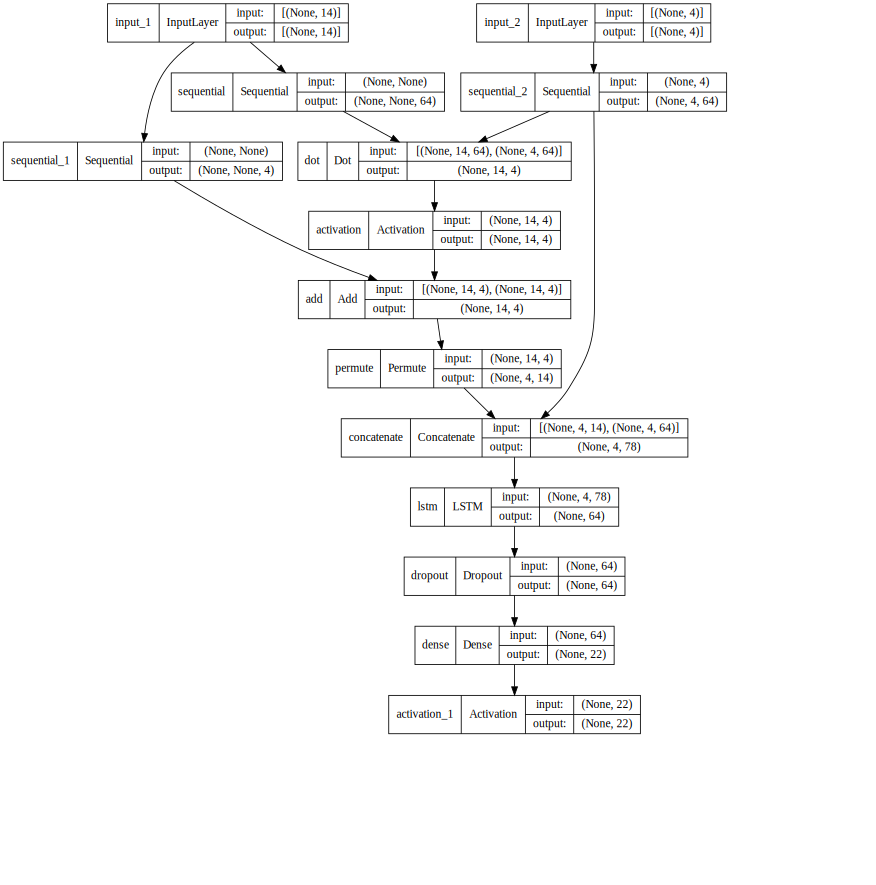

In [ ]:
from IPython.display import SVG

SVG(tf.keras.utils.model_to_dot(model,show_shapes= True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))

Model summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     1408        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 4, 64)        1408        ['input_2[0][0]']                
                                                                                              

## 1.5 Training

In this section we start the training procedure with fitting the data to the designed model.

Epoch 1/50
  2/313 [..............................] - ETA: 17s - loss: 1.6828 - accuracy: 0.3438

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


313/313 [==============================] - 20s 63ms/step - loss: 1.7013 - accuracy: 0.3050 - val_loss: 1.7060 - val_accuracy: 0.3280
Epoch 2/50
313/313 [==============================] - 20s 63ms/step - loss: 1.6944 - accuracy: 0.3055 - val_loss: 1.7127 - val_accuracy: 0.3350
Epoch 3/50
313/313 [==============================] - 19s 61ms/step - loss: 1.6917 - accuracy: 0.3178 - val_loss: 1.6975 - val_accuracy: 0.3350
Epoch 4/50
313/313 [==============================] - 20s 63ms/step - loss: 1.6886 - accuracy: 0.3189 - val_loss: 1.6998 - val_accuracy: 0.3350
Epoch 5/50
313/313 [==============================] - 19s 61ms/step - loss: 1.6786 - accuracy: 0.3234 - val_loss: 1.6870 - val_accuracy: 0.3320
Epoch 6/50
313/313 [==============================] - 20s 63ms/step - loss: 1.6772 - accuracy: 0.3236 - val_loss: 1.6833 - val_accuracy: 0.3500
Epoch 7/50
313/313 [==============================] - 20s 62ms/step - loss: 1.6722 - accuracy: 0.3267 - val_loss: 1.6754 - val_accuracy: 0.3410
Epo

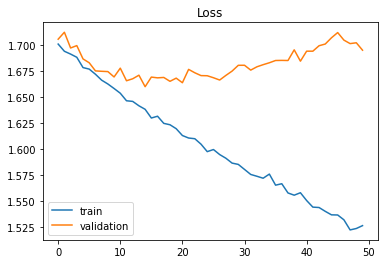

<Figure size 432x288 with 0 Axes>

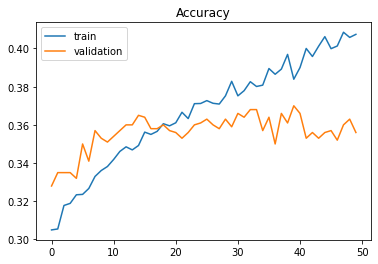

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
          validation_data=([inputs_test, queries_test], answers_test))

plot_loss(history,"Loss")
plot_acc(history,"Accuracy")

model.save('model.h5')

In [ ]:
train_epochs = 10
batch_size = 32
lstm_size = 64

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
313/313 [==============================] - 24s 68ms/step - loss: 1.9062 - accuracy: 0.1696 - val_loss: 1.8032 - val_accuracy: 0.1710
Epoch 2/10
313/313 [==============================] - 21s 67ms/step - loss: 1.8059 - accuracy: 0.1741 - val_loss: 1.7863 - val_accuracy: 0.2220
Epoch 3/10
313/313 [==============================] - 21s 67ms/step - loss: 1.7869 - accuracy: 0.2022 - val_loss: 1.7813 - val_accuracy: 0.2280
Epoch 4/10
313/313 [==============================] - 21s 67ms/step - loss: 1.7785 - accuracy: 0.2136 - val_loss: 1.7680 - val_accuracy: 0.2670
Epoch 5/10
313/313 [==============================] - 21s 66ms/step - loss: 1.7672 - accuracy: 0.2401 - val_loss: 1.7535 - val_accuracy: 0.2850
Epoch 6/10
313/313 [==============================] - 21s 66ms/step - loss: 1.7645 - accuracy: 0.2456 - val_loss: 1.7581 - val_accuracy: 0.2570
Epoch 7/10
313/313 [==============================] - 20s 65ms/step - loss: 1.7620 - accuracy: 0.2520 - val_loss: 1.7514 - val_accuracy:

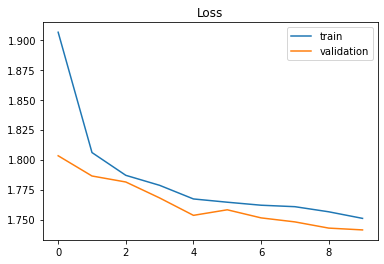

<Figure size 432x288 with 0 Axes>

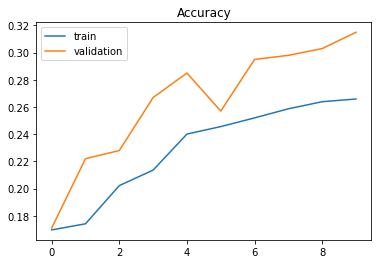

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
history1 = model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
          validation_data=([inputs_test, queries_test], answers_test))

plot_loss(history1,"Loss")
plot_acc(history1,"Accuracy")

model.save('model1.h5')

In [ ]:
train_epochs = 25
batch_size = 32
lstm_size = 64

Epoch 1/25
  2/313 [..............................] - ETA: 19s - loss: 1.7420 - accuracy: 0.2500

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


313/313 [==============================] - 21s 68ms/step - loss: 1.7506 - accuracy: 0.2698 - val_loss: 1.7320 - val_accuracy: 0.2960
Epoch 2/25
313/313 [==============================] - 21s 68ms/step - loss: 1.7451 - accuracy: 0.2784 - val_loss: 1.7240 - val_accuracy: 0.3070
Epoch 3/25
313/313 [==============================] - 21s 67ms/step - loss: 1.7453 - accuracy: 0.2770 - val_loss: 1.7234 - val_accuracy: 0.3060
Epoch 4/25
313/313 [==============================] - 21s 67ms/step - loss: 1.7398 - accuracy: 0.2822 - val_loss: 1.7173 - val_accuracy: 0.3230
Epoch 5/25
313/313 [==============================] - 20s 64ms/step - loss: 1.7391 - accuracy: 0.2850 - val_loss: 1.7138 - val_accuracy: 0.3190
Epoch 6/25
313/313 [==============================] - 20s 65ms/step - loss: 1.7359 - accuracy: 0.2862 - val_loss: 1.7159 - val_accuracy: 0.3140
Epoch 7/25
313/313 [==============================] - 20s 64ms/step - loss: 1.7354 - accuracy: 0.2874 - val_loss: 1.7179 - val_accuracy: 0.3130
Epo

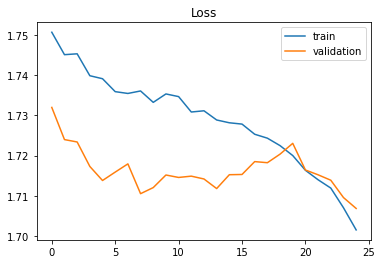

<Figure size 432x288 with 0 Axes>

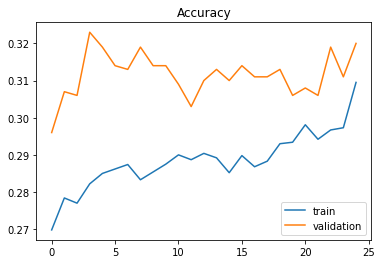

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
history2 = model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs,
          validation_data=([inputs_test, queries_test], answers_test))

plot_loss(history2,"Loss")
plot_acc(history2,"Accuracy")

model.save('model2.h5')

## 1.6 Testing and Analysis

Now we need to actually make predictions and check the performance of our trained model with some examples:

In [ ]:
for i in range(0,10):
    current_inp = test_stories[2*i]
    current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
    current_prediction = model.predict([current_story, current_query])
    current_prediction = idx_word[np.argmax(current_prediction)]
    print(' '.join(current_inp[0]), ' '.join(current_inp[1]), '| Prediction:', current_prediction, '| Ground Truth:', current_inp[2])
    print("-----------------------------------------------------------------------------------------")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


John travelled to the hallway . Mary journeyed to the bathroom . Where is John ? | Prediction: bathroom | Ground Truth: hallway
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Where is Sandra ? | Prediction: bathroom | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
John travelled to the hallway . Mary journeyed to the bathroom . Where is Sandra ? | Prediction: bathroom | Ground Truth: kitchen
-----------------------------------------------------------------------------------------
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: hallway | Ground Truth: garden
-----------------------------------------------------------------------------------------
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: hallway | Ground Trut

## 1.7 Custom Inputs

You can even write your example and test it with your model to see how powerful it is:

In [ ]:
print('-------------------------------------------------------------------------------------------')
print('Custom User Queries (Make sure there are spaces before each word)')
while 1:
    print('-------------------------------------------------------------------------------------------')
    print('Please input a story')
    user_story_inp = input().split(' ')
    print('Please input a query')
    user_query_inp = input().split(' ')
    user_story, user_query, user_ans = vectorize_stories([[user_story_inp, user_query_inp, '.']], word_idx, story_maxlen, query_maxlen)
    user_prediction = model.predict([user_story, user_query])
    user_prediction = idx_word[np.argmax(user_prediction)]
    print('Result')
    print(' '.join(user_story_inp), ' '.join(user_query_inp), '| Prediction:', user_prediction)

-------------------------------------------------------------------------------------------
Custom User Queries (Make sure there are spaces before each word)
-------------------------------------------------------------------------------------------
Please input a story
Sandra travelled to the kitchen . Sandra travelled to the hallway .
Please input a query
Where is Sandra ?


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Result
Sandra travelled to the kitchen . Sandra travelled to the hallway . Where is Sandra ? | Prediction: hallway
-------------------------------------------------------------------------------------------
Please input a story
Sandra travelled to the kitchen . Sandra travelled to the hallway . Mary went to the bathroom . Sandra moved to the garden .
Please input a query
Where is Sandra ?
Result
Sandra travelled to the kitchen . Sandra travelled to the hallway . Mary went to the bathroom . Sandra moved to the garden . Where is Sandra ? | Prediction: garden
-------------------------------------------------------------------------------------------
Please input a story
Sandra travelled to the kitchen . Sandra travelled to the hallway . Mary went to the bathroom . Sandra moved to the garden . Sandra travelled to the office . Daniel journeyed to the hallway .
Please input a query
Where is Daniel ?
Result
Sandra travelled to the kitchen . Sandra travelled to the hallway . Mary went to the b

KeyboardInterrupt: ignored

In [ ]:
# some examples:
# Mary went to the bathroom . John moved to the hallway . Mary travelled to the office . # Where is Mary ?
# Sandra travelled to the office . John journeyed to the garden .

As you understood how the model trained, please tell us about the pros and cons of the proposed model. How can we improve it if we want to use it in realistic task ? 

$\color{red}{\text{Write your answer in document}}$



#  2. Hands on SSL

In [1]:
import cv2
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt

## 2.1 prepare data

In [2]:
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
unlabeld_index = np.ones(y_train.shape, np.bool)

N = 20
for i in range(10):
  idx = np.where(y_train == i)[0][:N]
  unlabeld_index[idx] = 0

In [4]:
x_unlabeld = x_train[np.where(unlabeld_index)[0], ...]

x_train = x_train[np.where(~unlabeld_index)[0], ...]
y_train = y_train[np.where(~unlabeld_index)[0], ...]

In [5]:
# examples of categorical crossentropy
cce = keras.losses.CategoricalCrossentropy()

# a labeled data from the second class
y_true = [[0, 1, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# an ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.05, 0.95, 0, 0]]
print(cce(y_true, y_pred).numpy())

# another ulabeled data
y_true = [[0, 0, 0, 0]]
y_pred = [[0.1, 0.4, 0.3, 0.2]]
print(cce(y_true, y_pred).numpy())

0.051293306
0.0
0.0


In [11]:
from tensorflow.keras.utils import to_categorical

x_train = x_train.reshape(x_train.shape[0], 32, 32, 3)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3)
print(x_train.shape, x_test.shape)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

(200, 32, 32, 3) (10000, 32, 32, 3)


In [12]:
number_of_classes = 10
batch_size = 32

In [13]:
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,\
 BatchNormalization, Dropout, Input, Activation

import tensorflow


def get_model():
    input_shape = x_train.shape[1:]

    model = tensorflow.keras.Sequential([Input(shape=input_shape),
    Conv2D(32, (5, 5), padding="same"),
    Activation("relu"),
    BatchNormalization(axis=-1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, (5, 5), padding="same"),
    Activation("relu"),
    BatchNormalization(axis=-1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Conv2D(128, (5, 5), padding="same"),
    Activation("relu"),
    BatchNormalization(axis=-1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(512),
    Activation("relu"),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10),
    Activation("softmax"),
    ])

    return model

In [16]:
model = get_model()

model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
validation = [x_test, y_test]

history = model.fit(x_train,
                    y_train,
                    batch_size=batch_size,
                    epochs=50,
                    validation_data=validation)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        2432      
                                                                 
 activation_10 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_8 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)       

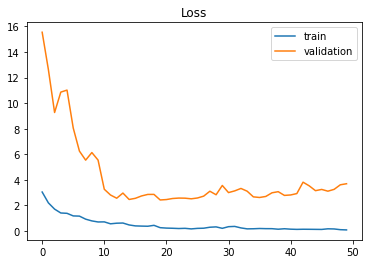

<Figure size 432x288 with 0 Axes>

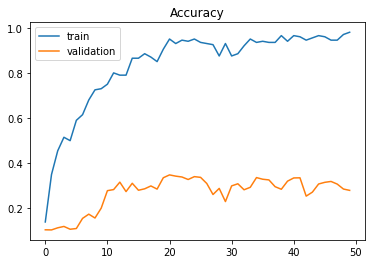

<Figure size 432x288 with 0 Axes>

In [17]:
trianing_loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(trianing_loss, label='Training loss')
plt.plot(validation_loss, label='Validation loss')
plt.title('Loss')
plt.legend(['train', 'validation'])
plt.figure()
plt.show()
trian_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
plt.plot(trian_acc, label='Training acc')
plt.plot(validation_acc, label='Validation acc')
plt.title('Accuracy')
plt.legend(['train', 'validation'])
plt.figure()
plt.show()

# Part2. 

In [6]:
def rotate(img, index):
  x = np.rot90(img, k=index)
  y = np.zeros(4)
  y[index] = 1
  return x, y

def ssl_data(data):
  x_rotated = []
  y_rotated = []
  for temp in data:
    for index in range(4):
      x, y = rotate(temp, index)
      x_rotated.append(x)
      y_rotated.append(y)
  return x_rotated, y_rotated

x_unlabeld_normalized = np.divide(x_unlabeld.astype('float32'), 255)
x_rotated, y_rotated = ssl_data(x_unlabeld_normalized)
x_rotated_arr = np.array(x_rotated)
y_rotated_arr = np.array(y_rotated)

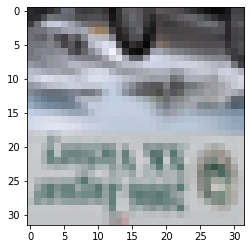

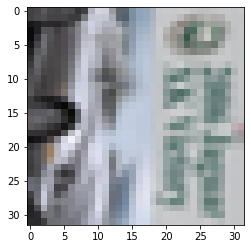

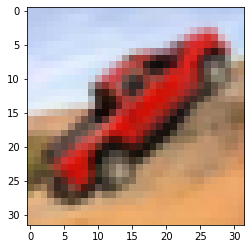

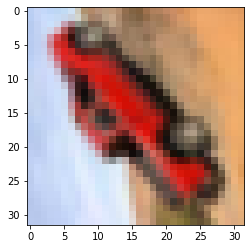

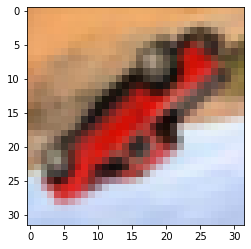

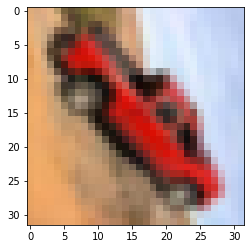

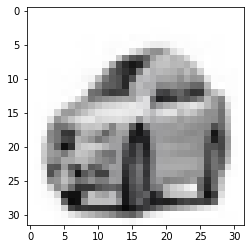

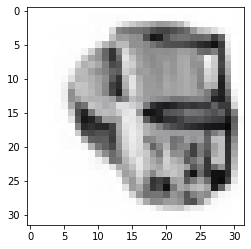

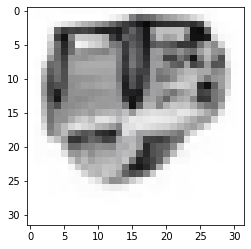

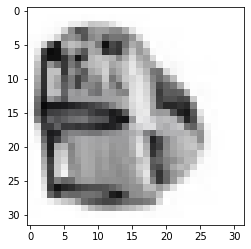

In [15]:
from matplotlib import pyplot as plt

for i in range(10):
    data = x_rotated_arr[i+10]
    plt.imshow(data, interpolation='nearest')
    data = y_rotated_arr[i]
    # print(y_train_rotate[2*i + 1])
    plt.show()

In [16]:
import tensorflow

def get_model():
  model = tensorflow.keras.Sequential([
  Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
  BatchNormalization(),
  Conv2D(32, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Dropout(0.3),
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  Conv2D(64, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Dropout(0.3),
  Conv2D(128, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  Conv2D(128, (3, 3), activation='relu', padding='same'),
  BatchNormalization(),
  MaxPooling2D((2, 2)),
  Dropout(0.3),
  Flatten(),
  Dense(64, activation='relu', kernel_initializer='he_uniform'),
  Dense(4, activation='softmax')])
  return model

In [18]:
model2 = get_model()
model2.summary()


model2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(x_rotated_arr,
                      y_rotated_arr,
                      batch_size=128,
                      epochs=13)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

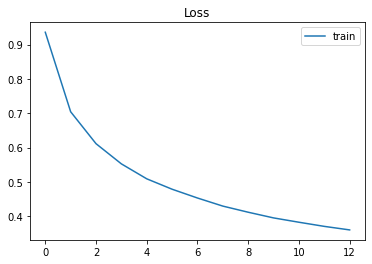

<Figure size 432x288 with 0 Axes>

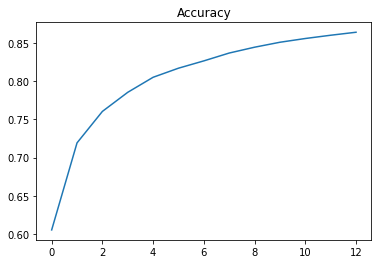

<Figure size 432x288 with 0 Axes>

In [19]:
trianing_loss = history2.history['loss']
plt.plot(trianing_loss, label='Training loss')
plt.title('Loss')
plt.legend(['train', 'validation'])
plt.figure()
plt.show()
trian_acc = history2.history['accuracy']
plt.plot(trian_acc, label='Training acc')
plt.title('Accuracy')
plt.figure()
plt.show()

In [51]:
from keras.models import Model


normalized_input = np.divide(x_train.astype('float32'), 255)
reshaped_output = to_categorical(y_train, num_classes=10)

print(normalized_input.shape)
print(reshaped_output.shape)
model2_2 = keras.Model(model2.inputs,
                       Dense(10 ,activation='softmax')(model2.layers[-2].output))
model2_2.summary()
model2_2.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
model2_2.fit(normalized_input,
             reshaped_output,
             batch_size=64, epochs=30)

(50000, 32, 32, 3)
(50000, 10)
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22_input (InputLayer  [(None, 32, 32, 3)]      0         
 )                                                               
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_24 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_25 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                           

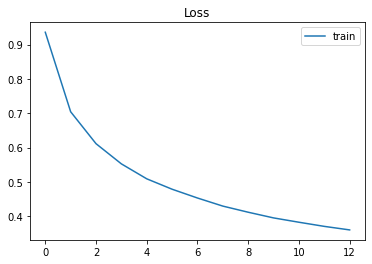

<Figure size 432x288 with 0 Axes>

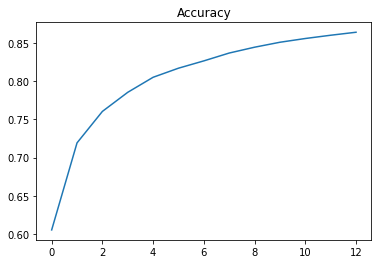

<Figure size 432x288 with 0 Axes>

In [20]:
trianing_loss = history2.history['loss']
plt.plot(trianing_loss, label='Training loss')
plt.title('Loss')
plt.legend(['train', 'validation'])
plt.figure()
plt.show()
trian_acc = history2.history['accuracy']
plt.plot(trian_acc, label='Training acc')
plt.title('Accuracy')
plt.figure()
plt.show()

# Part3.

In [ ]:
from sklearn.utils import shuffle
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
normalized_input = np.divide(x_train.astype('float32'), 255)
reshaped_output = to_categorical(y_train, num_classes=10)
x_labeled_rotated, y_labeled_rotated = ssl_data(normalized_input)
y_train_repeat = np.repeat(y_train, 4)
y_train_repeat_onehot = to_categorical(y_train_repeat, num_classes=10)
y_unlabeld = np.zeros((x_unlabeld.shape[0]*4, 10))
x_train_all = np.concatenate((x_labeled_rotated, x_rotated_arr))
y_train_class = np.concatenate((y_train_repeat_onehot, y_unlabeld))
y_train_rotation = np.concatenate((y_labeled_rotated, y_rotated_arr))
x_train_all, y_train_class, y_train_rotation = shuffle(x_train_all,
                                                       y_train_class,
                                                       y_train_rotation,
                                                       random_state=20)

In [ ]:
r = 0
new_y_test = np.repeat(r, y_test.shape[0])
new_y_test_rotation = to_categorical(new_y_test, num_classes=4)
history3_3 = model3.fit(x_train_all, [y_train_class, y_train_rotation], validation_data=(x_test_normalized, [y_test_onehot, new_y_test_rotation]), batch_size=256, epochs=10)

In [ ]:
model3.compile(optimizer=opt, 
               loss={
                   'class_num_output': 'categorical_crossentropy', 
                   'rotation_degree_output': 'categorical_crossentropy'},
               loss_weights={
                   'class_num_output': 2., 
                   'rotation_degree_output': 10.},
               metrics={
                   'class_num_output': 'accuracy',
                   'rotation_degree_output': 'accuracy'})

In [ ]:
history3 = model3.fit(x_train_all, [y_train_class, y_train_rotation], validation_data=(x_test_normalized, [y_test_onehot, y_test_rotation]), batch_size=256, epochs=10)